In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif



In [2]:
df = pd.read_csv('fraud_dataset.csv')
df


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


# 1. Data Loading and Feature Engineering

In [2]:

# Data Preprocessing
def preprocess_data(df):
    # Separate features and target
    X = df.drop('isFraud', axis=1)
    y = df['isFraud']
    
    # Feature selection to reduce correlation and select important features
    selector = SelectKBest(score_func=f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    X = pd.DataFrame(X_selected, columns=selected_features)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler, selector, selected_features

In [4]:

# Handle Class Imbalance
def balance_data(X_train, y_train):
    smote = SMOTE(random_state=42, sampling_strategy='minority')
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print("Class distribution after SMOTE:")
    print(pd.Series(y_train_res).value_counts())
    return X_train_res, y_train_res

In [5]:

def load_and_engineer_features(df):
    # Create new features based on the existing data
    df['hour_of_day'] = np.random.randint(0, 24, size=len(df))  # Simulating transaction time
    df['balance_change_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
    df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
    df['amount_to_orig_balance'] = df['amount'] / (df['oldbalanceOrg'] + 1)  # Avoid division by zero
    df['amount_to_dest_balance'] = df['amount'] / (df['oldbalanceDest'] + 1)
    
    # Add a column for total balance change
    df['total_balance_change'] = df['balance_change_orig'] + df['balance_change_dest']
    
    # Drop original columns that might leak target information or are redundant
    columns_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # One-hot encode transaction type
    df = pd.get_dummies(df, columns=['type'], prefix='type', drop_first=True)
    
    return df




In [7]:
def analyze_missing_values(df):
    """
    Prints the number of missing values per column and visualizes them using a heatmap.
    
    Parameters:
        df (DataFrame): The input DataFrame.
    """
    print("\n Missing Values per Column:")
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "No missing values found.")

    # Heatmap visualization
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='coolwarm', linewidths=0.5)
    plt.title("Missing Data Heatmap", fontsize=14)
    plt.show()


In [9]:
def plot_numerical_distributions(df, bins=30, figsize=(12, 10)):
    """
    Plots histograms for all numerical columns in the DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame.
        bins (int): Number of bins for the histograms.
        figsize (tuple): Figure size for the plot.
    """
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numerical_cols].hist(figsize=figsize, bins=bins, edgecolor='black')

    plt.suptitle("Histograms of Numerical Features", size=16)
    plt.tight_layout()
    plt.show()


In [11]:
def plot_scatter_matrix(df, target_col='isFraud'):
    numerical = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numerical = [col for col in numerical if col != target_col]
    
    sns.pairplot(df[numerical[:4] + [target_col]], hue=target_col, palette='husl')
    plt.suptitle("Scatter Plot Matrix of Selected Features", y=1.02)
    plt.show()


In [13]:
def plot_histograms(df, target_col='isFraud', bins=30):
   
    numerical = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numerical = [col for col in numerical if col != target_col]

    df[numerical].hist(figsize=(14, 12), bins=bins, edgecolor='black')
    plt.suptitle("Histogram of Numerical Features (Excluding Target)", fontsize=16)
    plt.tight_layout()
    plt.show()


In [15]:
def plot_boxplots(df, exclude_columns=None):
    """
    Plots boxplots for each numerical column in the dataframe, excluding specified columns.
    
    Parameters:
    - df: pandas DataFrame
    - exclude_columns: list of column names to exclude from boxplot (e.g., target or categorical cols)
    """
    if exclude_columns is None:
        exclude_columns = []
    
    # Select only numerical columns
    numerical_cols = df.select_dtypes(include=np.number).columns.difference(exclude_columns)
    
    plt.figure(figsize=(16, 4 * ((len(numerical_cols) // 3) + 1)))
    
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
        sns.boxplot(data=df[col])
        plt.title(f"Boxplot of {col}")
        plt.tight_layout()
    
    plt.show()


In [21]:


# Visualization Functions and  Feature Importance 
def plot_correlation_matrix(df):
    # Plot correlation matrix after scaling
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.show()


def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

In [23]:


# Bivariate Analysis (Optimized)
def bivariate_analysis(df):
    # Relationship between features and target variable (isFraud)
    plt.figure(figsize=(10, 6))
    sns.countplot(x='type_CASH_OUT', hue='isFraud', data=df)
    plt.title('Fraud Distribution across CASH_OUT Transactions')
    plt.show()

    # Boxplot for numerical features
    numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
    selected_features = numerical_features[:5]  # Limiting to the first 5 features for speed

    for feature in selected_features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='isFraud', y=feature, data=df)
        plt.title(f'Comparison of {feature} between Fraud and Non-Fraud')
        plt.show()

In [25]:
# Target Variable Analysis

def analyze_target_distribution(df, target_col='isFraud'):
    """
    Plots the distribution of the binary target variable and how numerical features relate to it.
    """
    # Plot target variable distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x=target_col, data=df)
    plt.title(f"Target Variable Distribution: {target_col}")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
    plt.show()

    # Numerical columns (excluding the target)
    numeric_cols = df.select_dtypes(include=np.number).columns.difference([target_col])

    # Boxplots of each numerical column vs target
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=target_col, y=col, data=df)
        plt.title(f"{col} by Target Class ({target_col})")
        plt.xlabel("Target Class")
        plt.ylabel(col)
        plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
        plt.tight_layout()
        plt.show()
    
    print("Target variable analysis completed.")


In [27]:
def plot_scatter_vs_target(df, target_col='isFraud', top_n=6):
    numeric_cols = df.select_dtypes(include=['float64', 'int64'])
    corr_with_target = numeric_cols.corr()[target_col].abs().sort_values(ascending=False)
    
    # Top correlated features excluding target
    top_features = corr_with_target.drop(target_col).head(top_n).index.tolist()
    
    for feature in top_features:
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=feature, y=target_col, data=df.sample(3000, random_state=42), alpha=0.3)
        plt.title(f"{feature} vs {target_col}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [29]:
def fast_correlation_heatmap(df):
    plt.figure(figsize=(12, 8))
    corr = df.corr()
    sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()


In [31]:
from sklearn.decomposition import PCA

def plot_pca_2d(df, target_col='isFraud'):
    features = df.select_dtypes(include=['float64', 'int64']).drop(columns=[target_col], errors='ignore')
    labels = df[target_col]

    # Reduce to 2D
    pca = PCA(n_components=2)
    components = pca.fit_transform(features)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=labels, palette='coolwarm', alpha=0.5)
    plt.title("PCA - 2D Projection of Features")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [33]:
def main(df):
    df = load_and_engineer_features(df)
    analyze_missing_values(df)
    analyze_target_distribution(df)
    plot_numerical_distributions(df)
    plot_boxplots(df, exclude_columns=['isFraud'])
    bivariate_analysis(df)
    plot_correlation_matrix(df.drop('isFraud', axis=1))
    plot_scatter_matrix(df)
    plot_scatter_vs_target(df)
    fast_correlation_heatmap(df)
    plot_pca_2d(df)

    X_train, X_test, y_train, y_test, scaler, selector, selected_features = preprocess_data(df)
    X_train_res, y_train_res = balance_data(X_train, y_train)
    # Placeholder: Train and compare multiple models here
    print("✅ Data ready for model training. Proceed with model comparisons.")


In [35]:
df = pd.read_csv('fraud_dataset.csv')

In [36]:
df = load_and_engineer_features(df)



🔍 Missing Values per Column:
No missing values found.


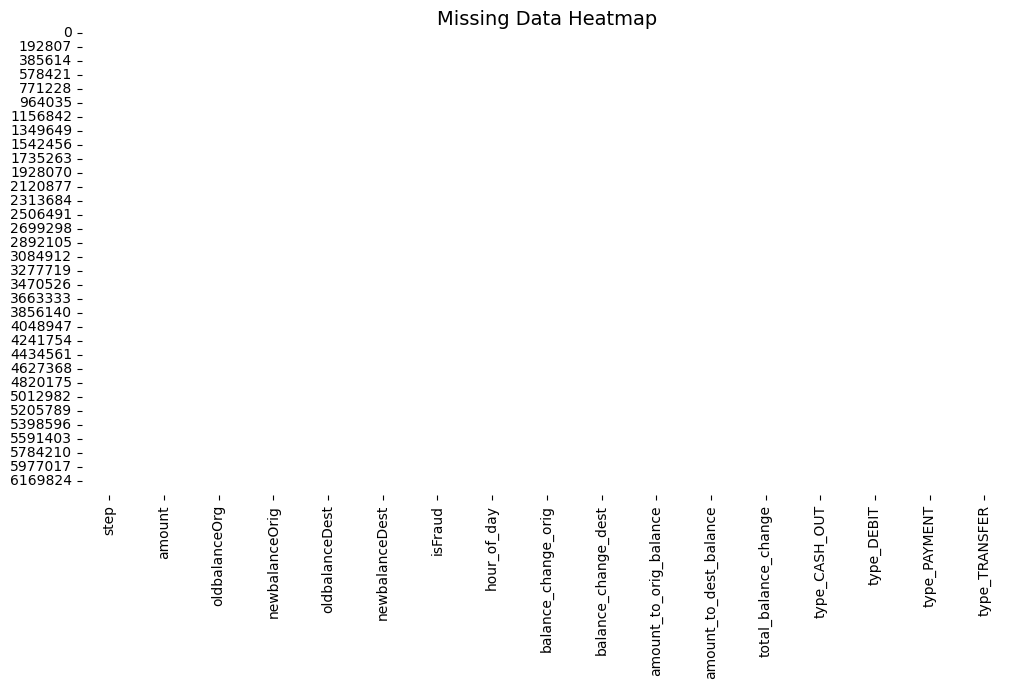

In [42]:
analyze_missing_values(df)


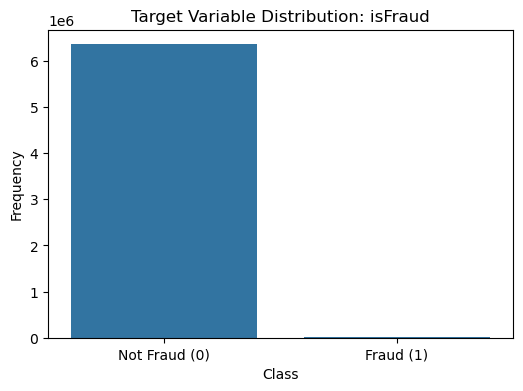

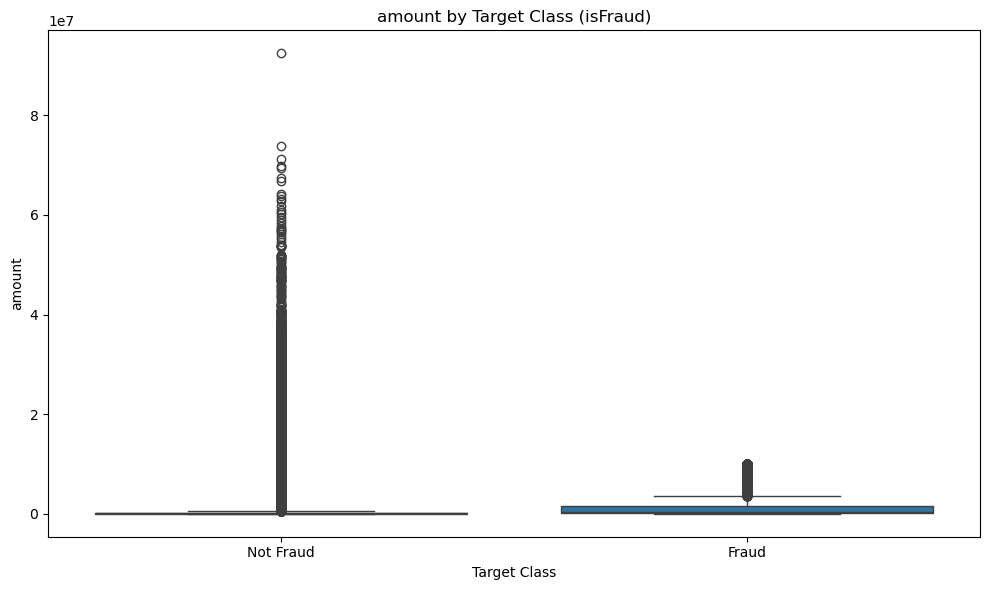

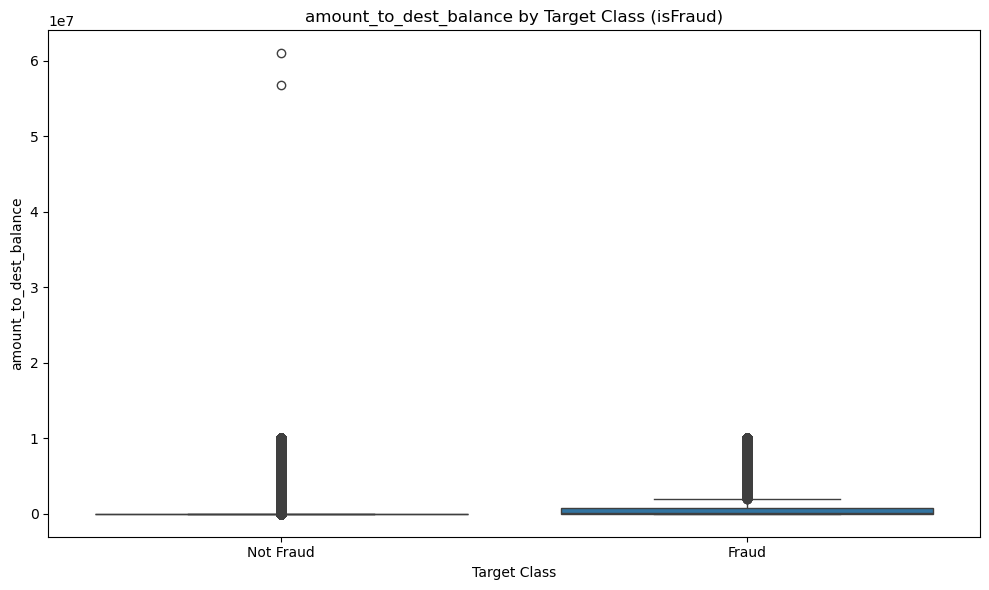

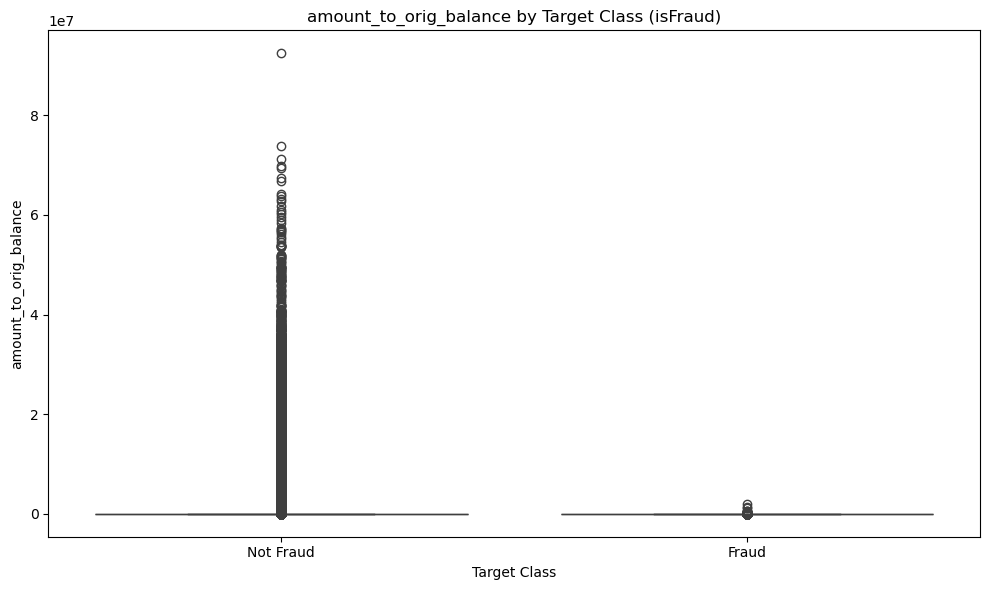

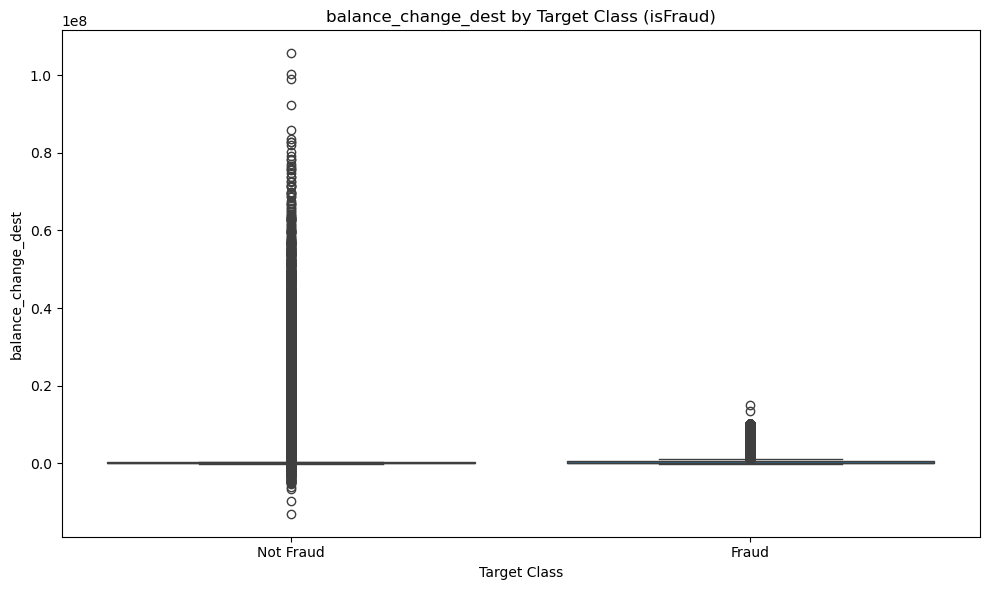

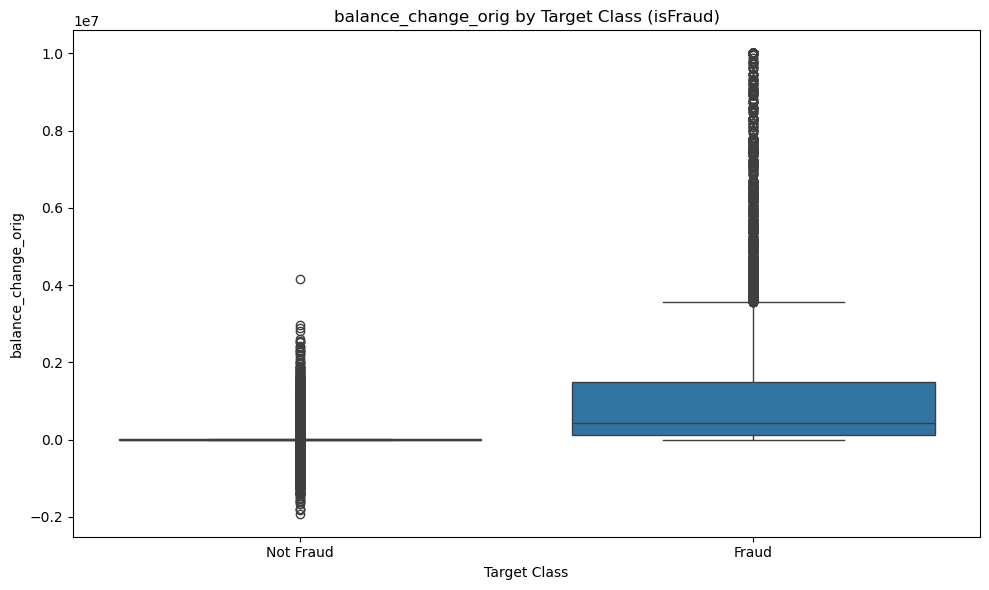

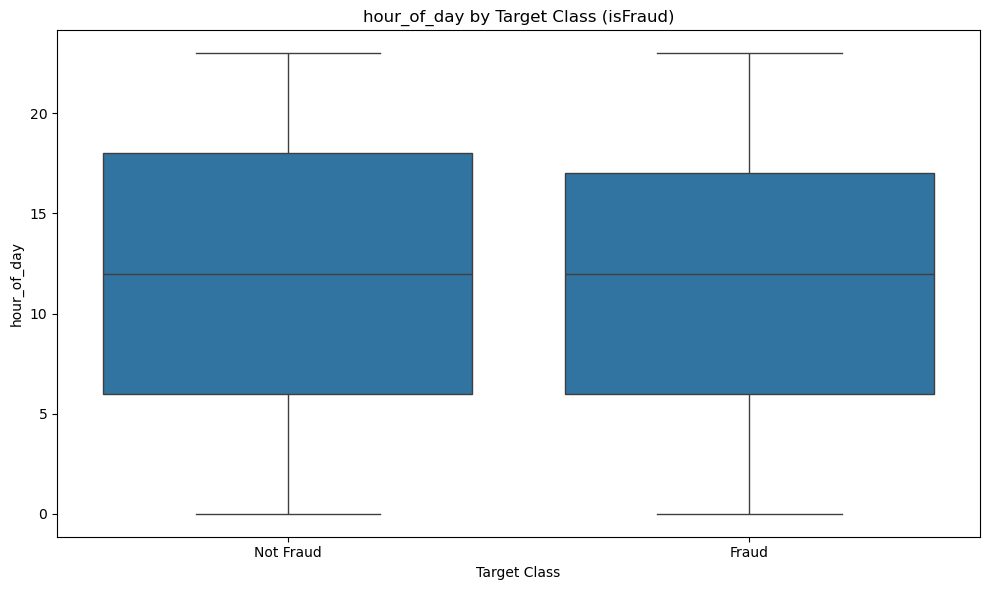

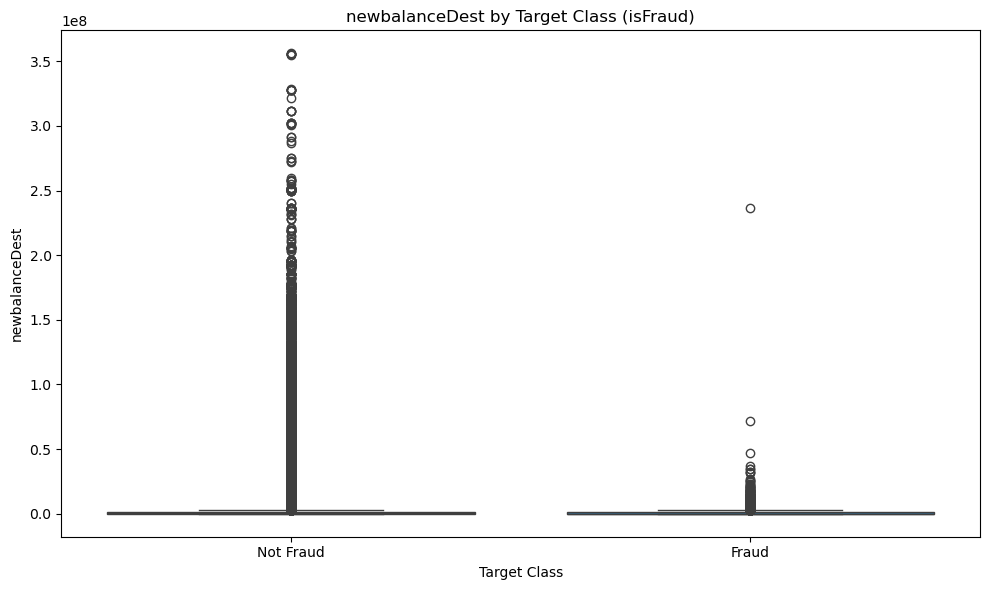

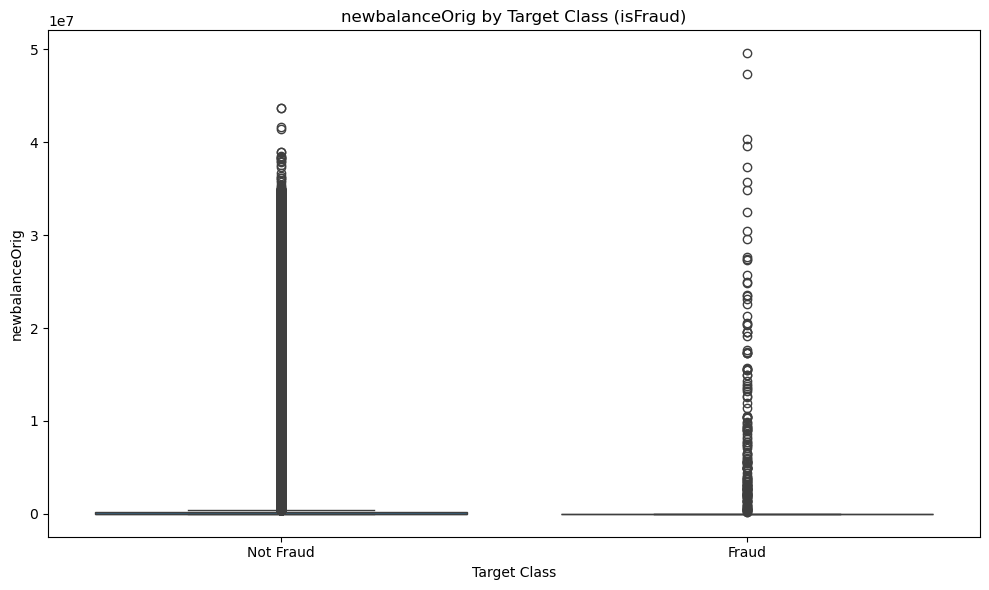

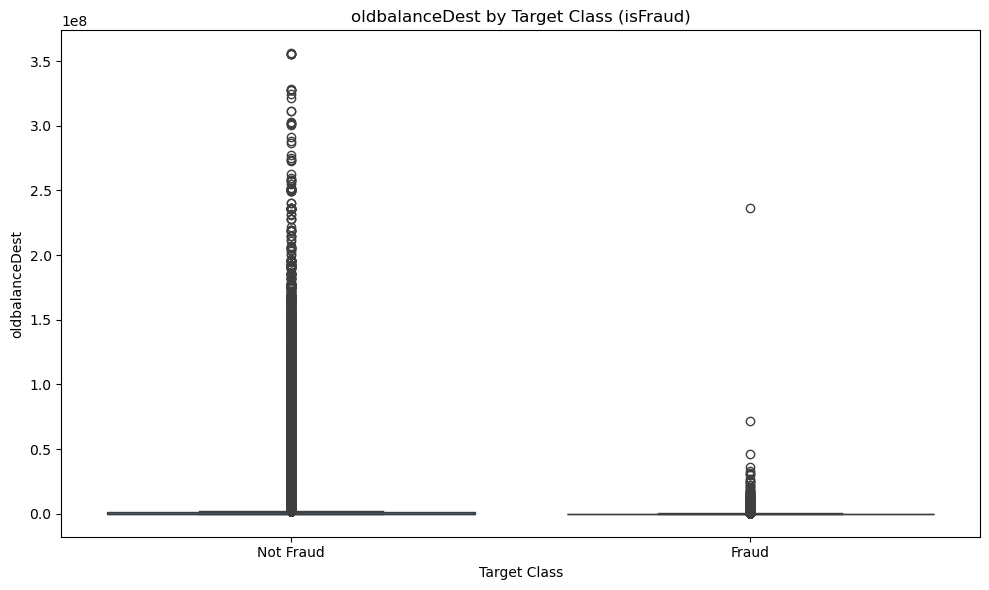

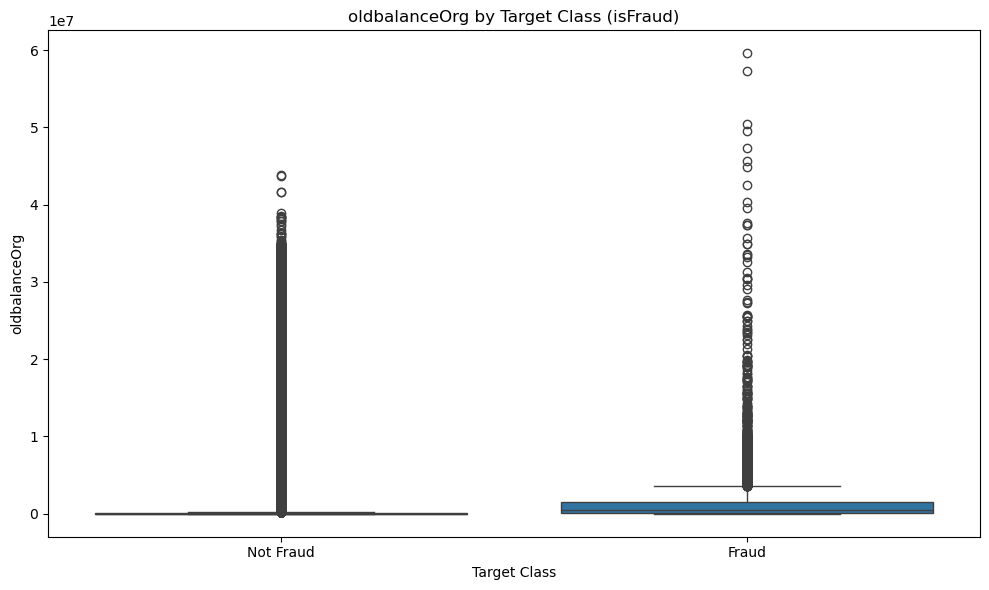

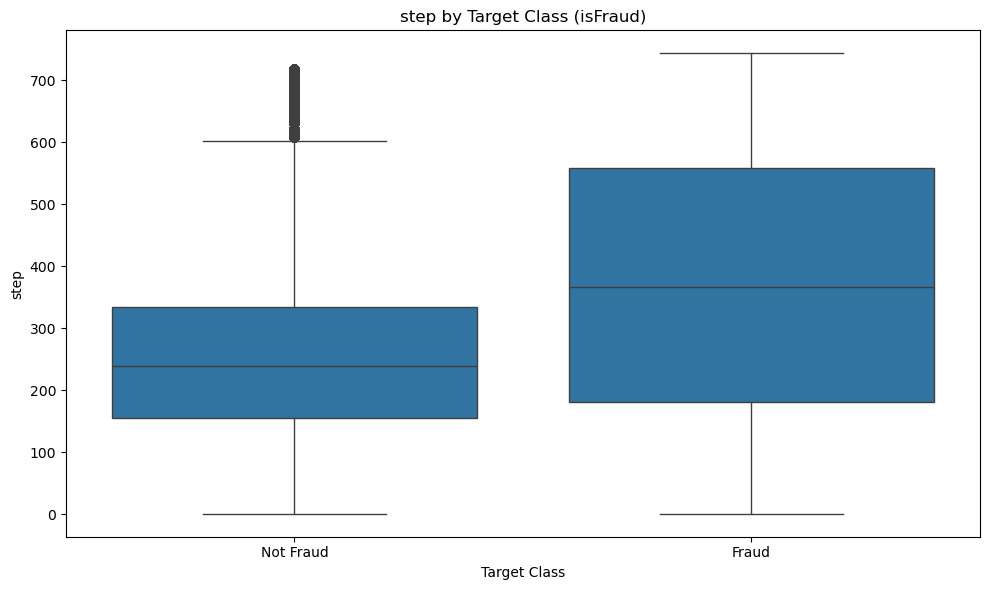

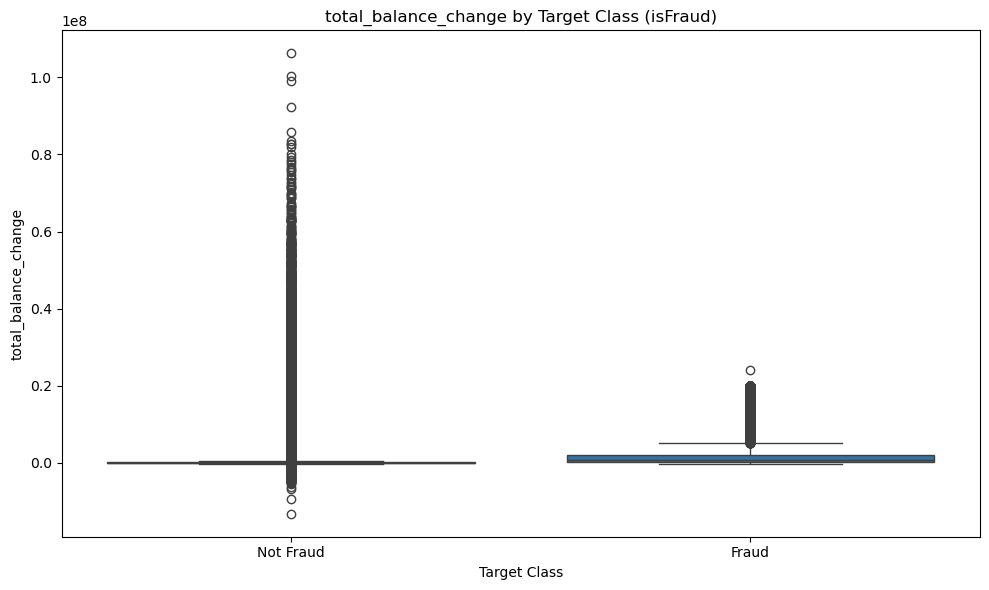

Target variable analysis completed.


In [45]:
analyze_target_distribution(df)


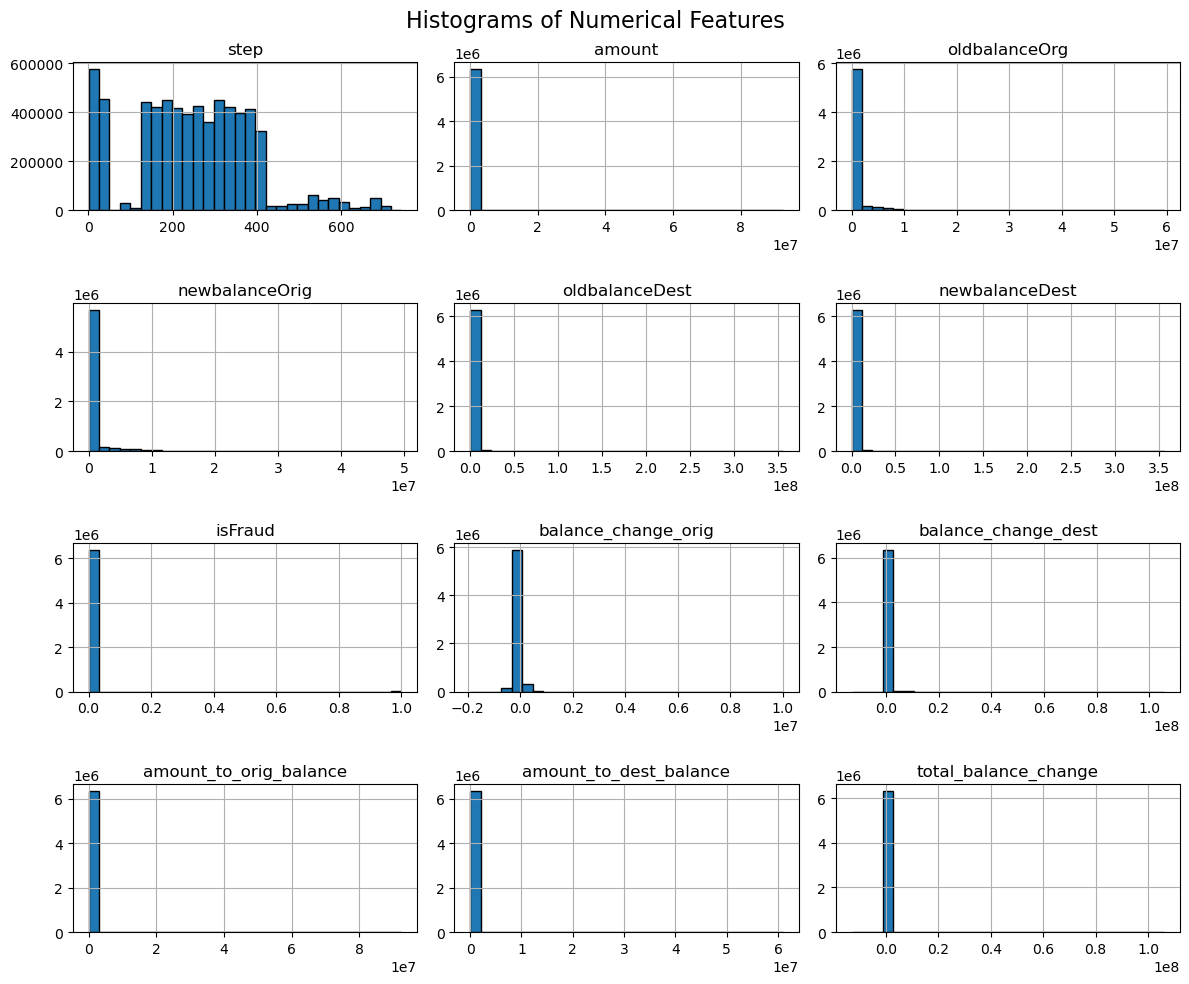

In [47]:
plot_numerical_distributions(df)


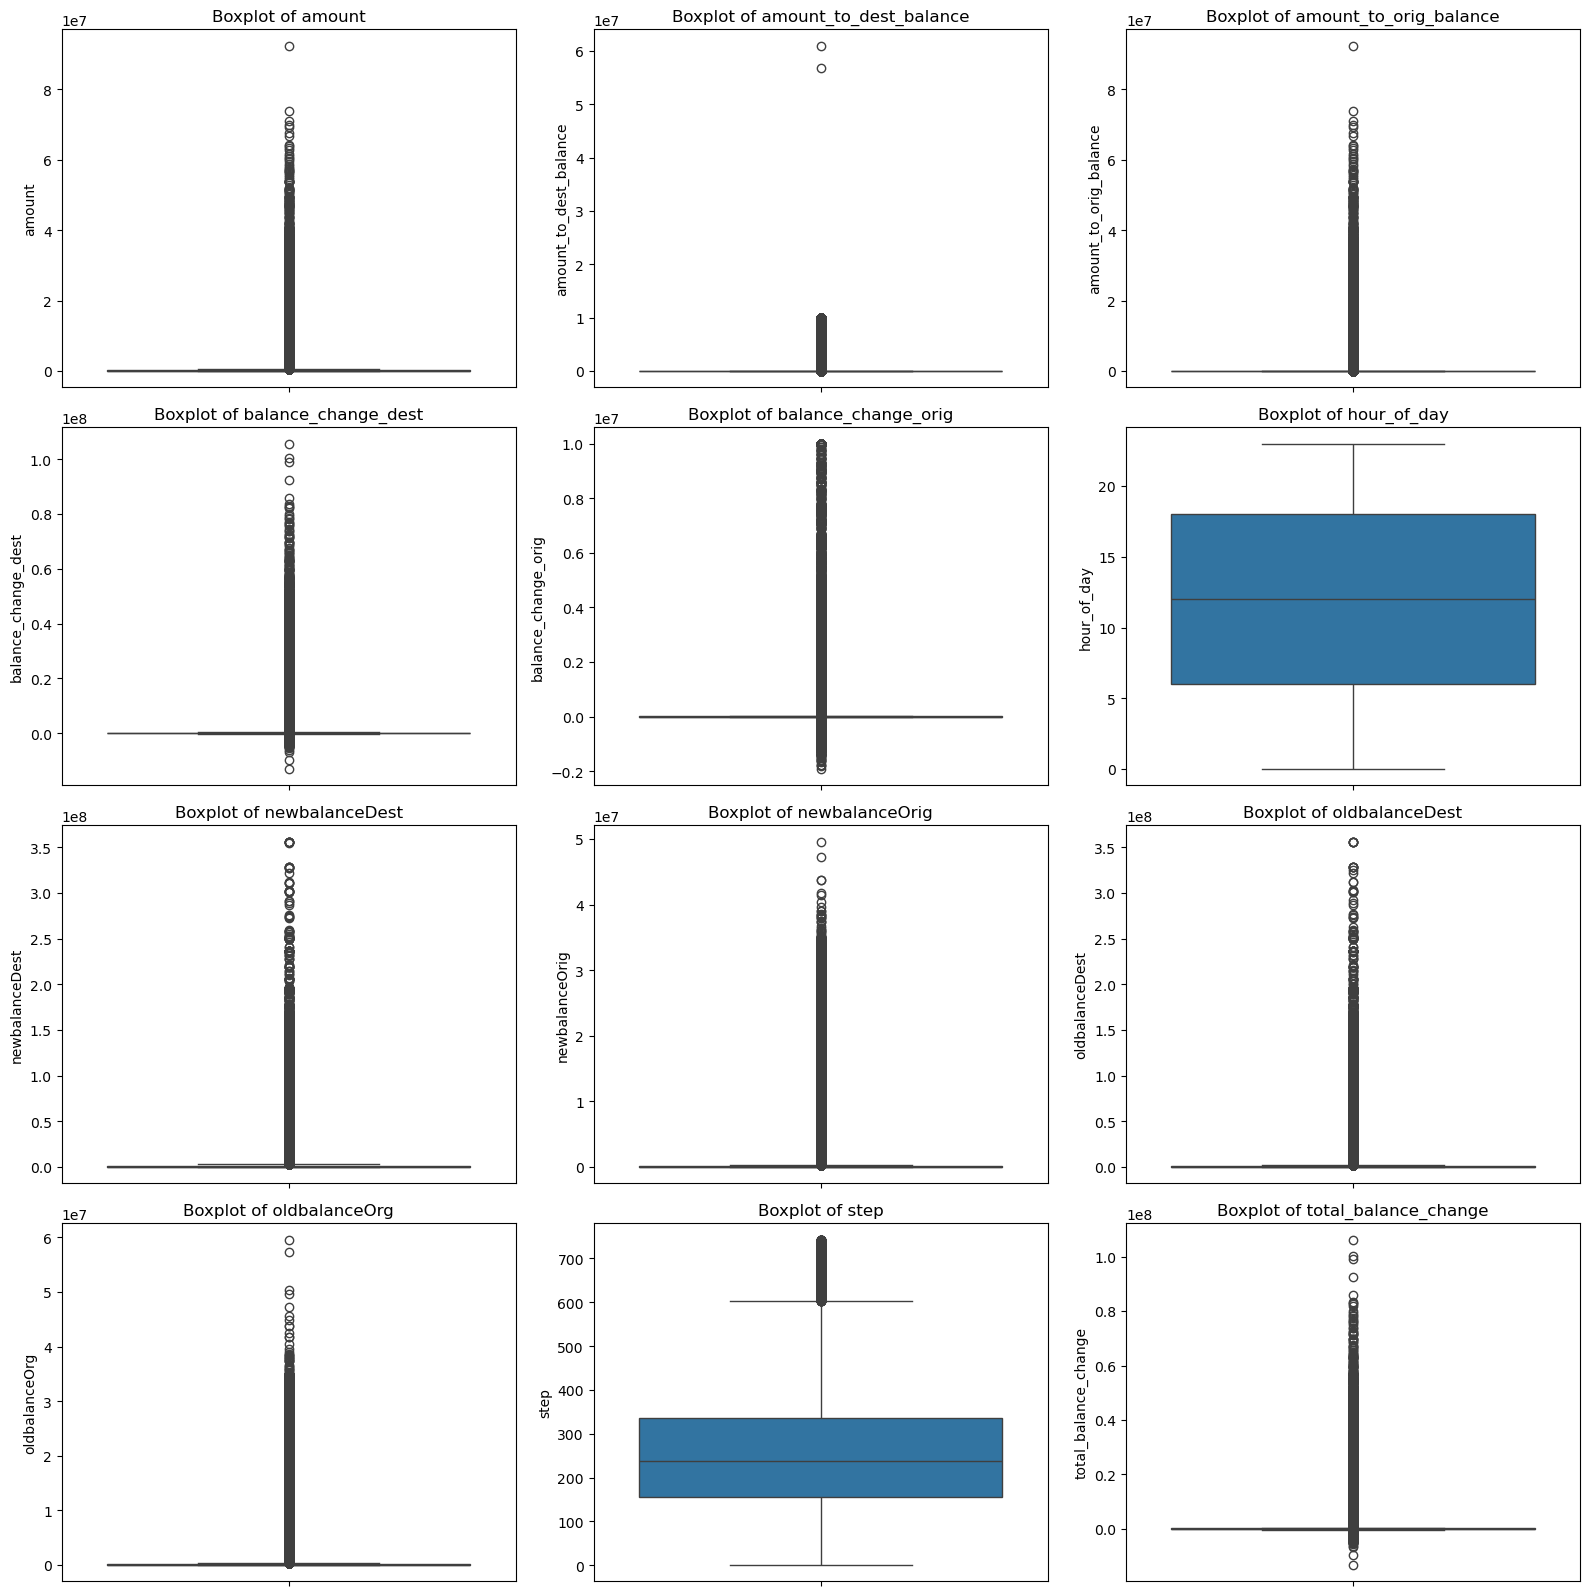

In [49]:
plot_boxplots(df, exclude_columns=['isFraud'])

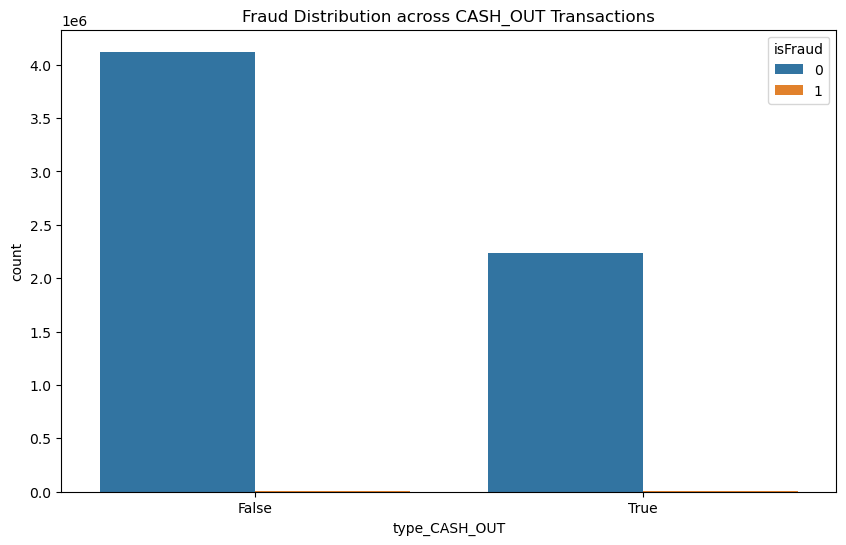

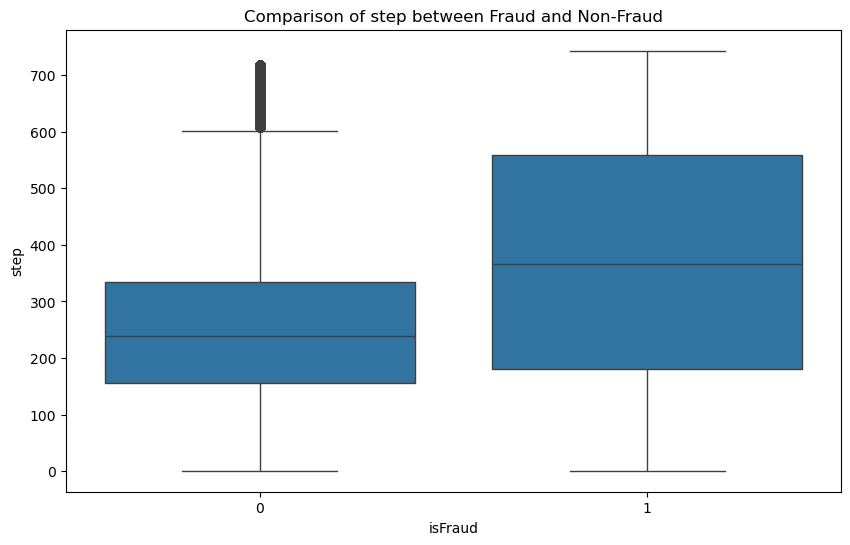

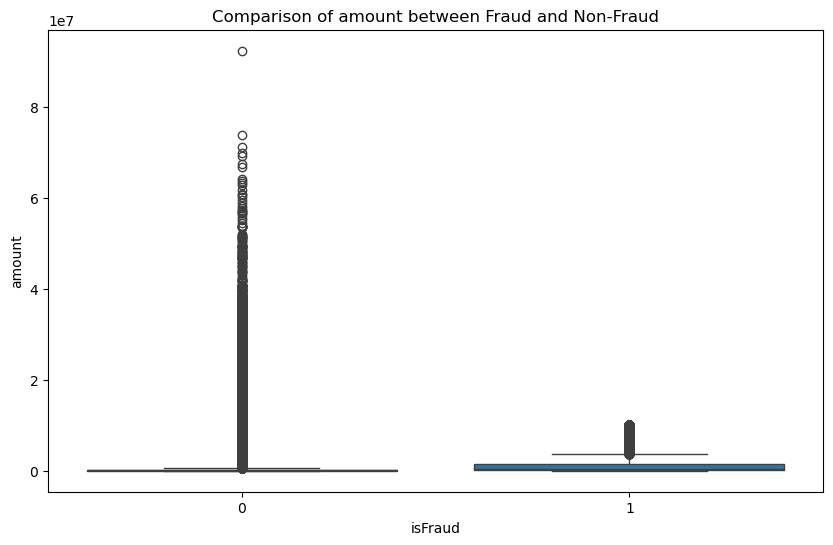

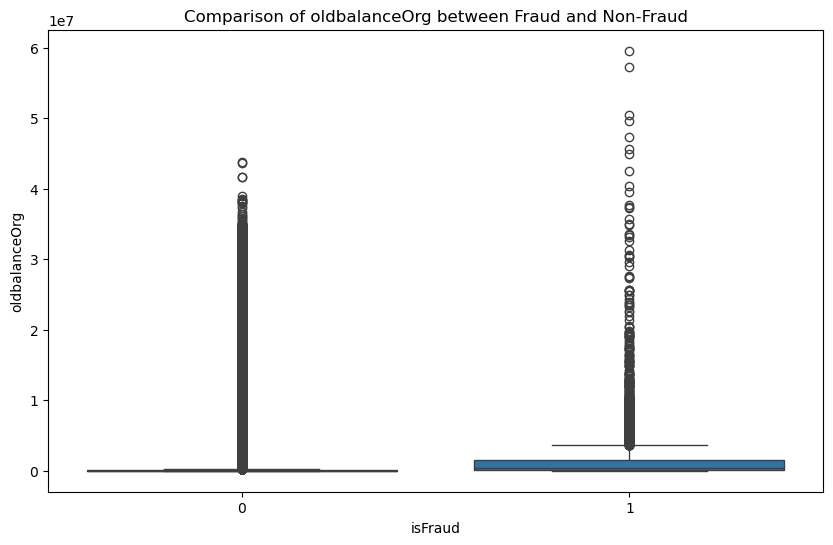

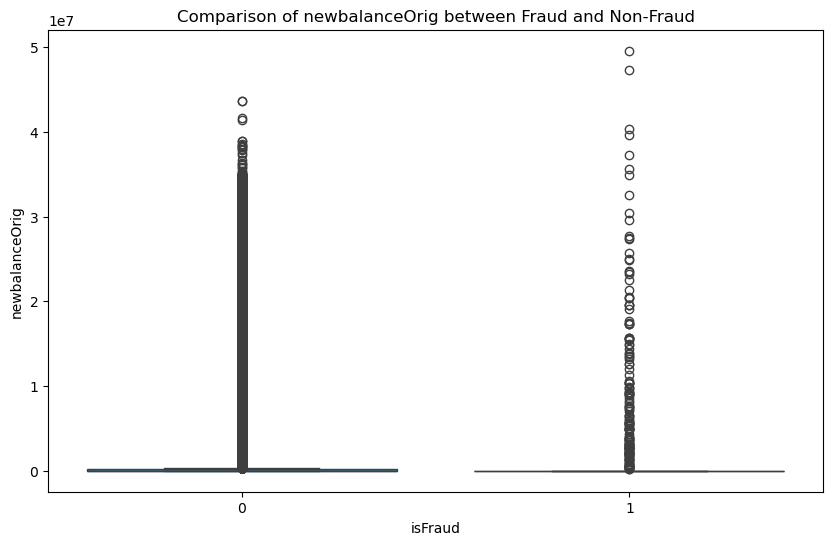

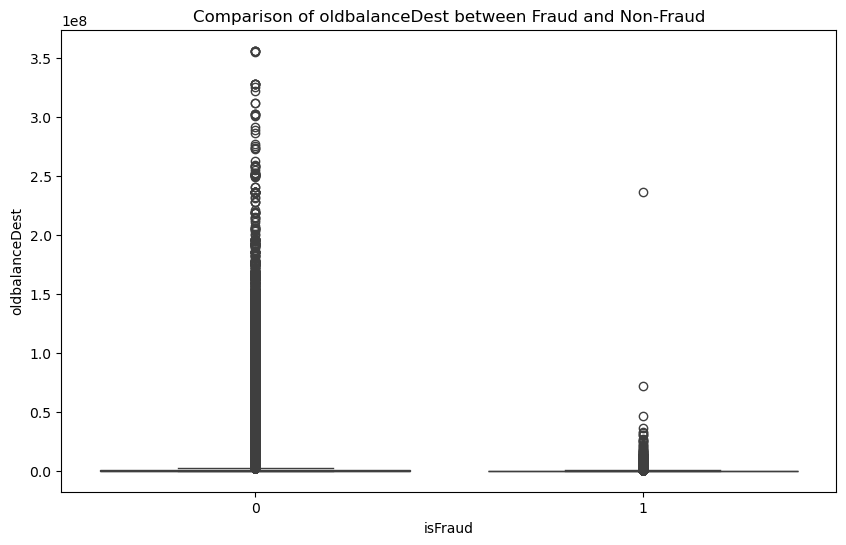

In [51]:
bivariate_analysis(df)

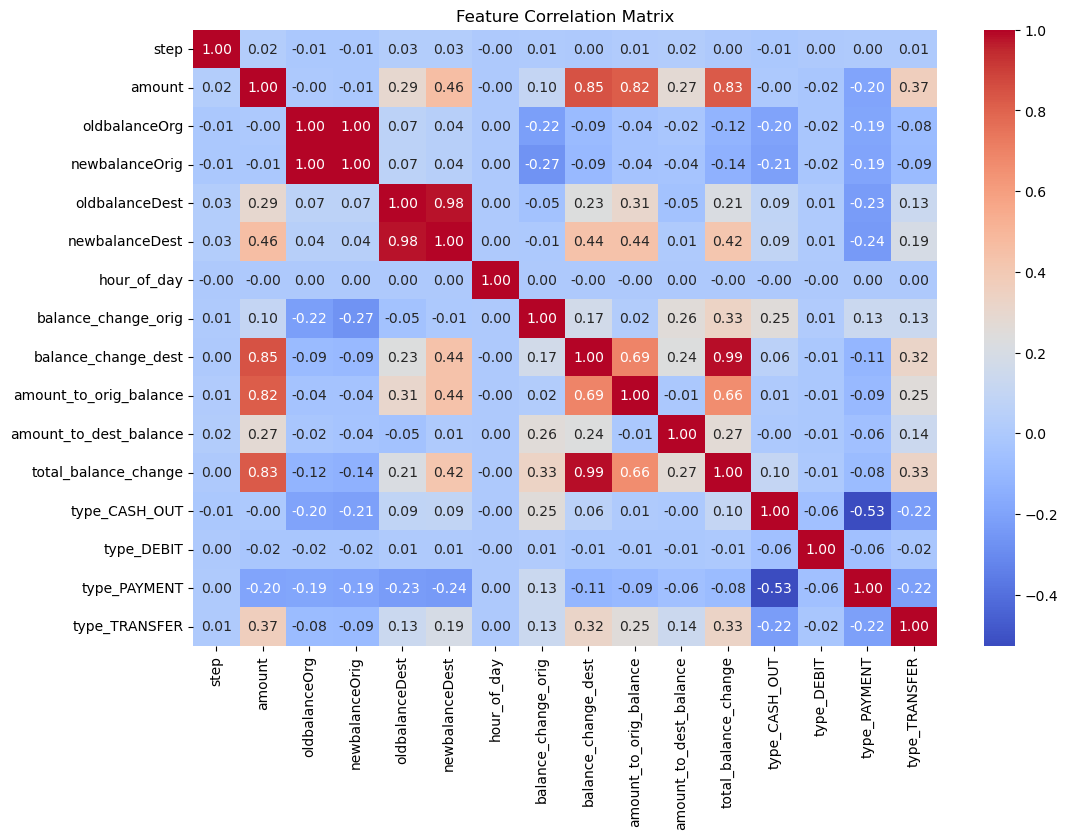

In [52]:
plot_correlation_matrix(df.drop('isFraud', axis=1))

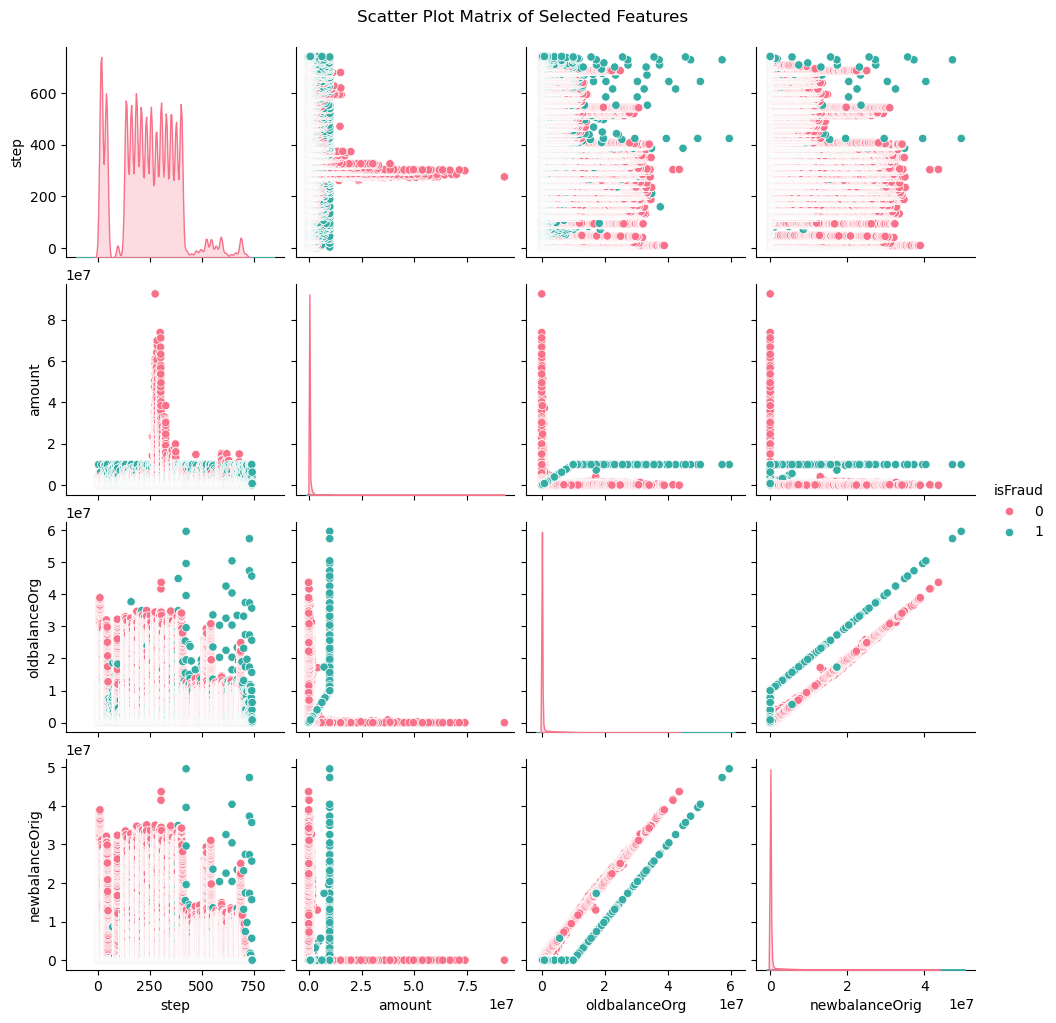

In [55]:

plot_scatter_matrix(df)


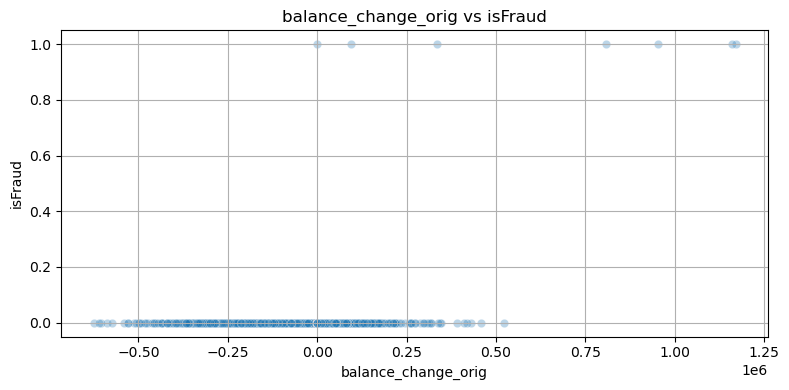

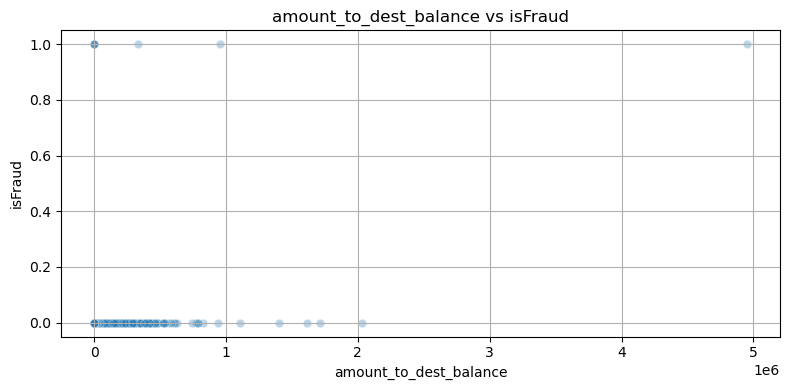

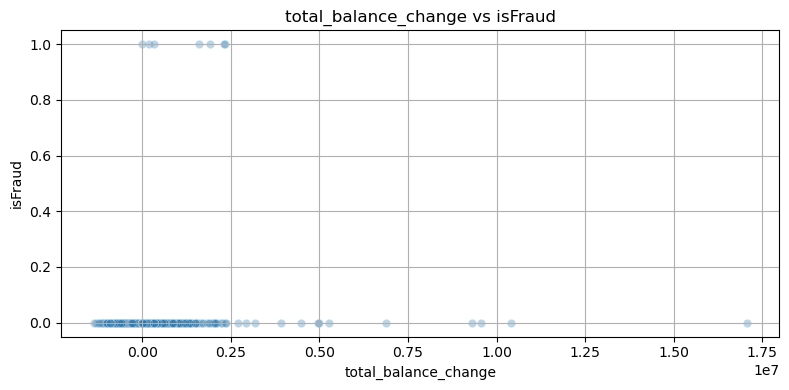

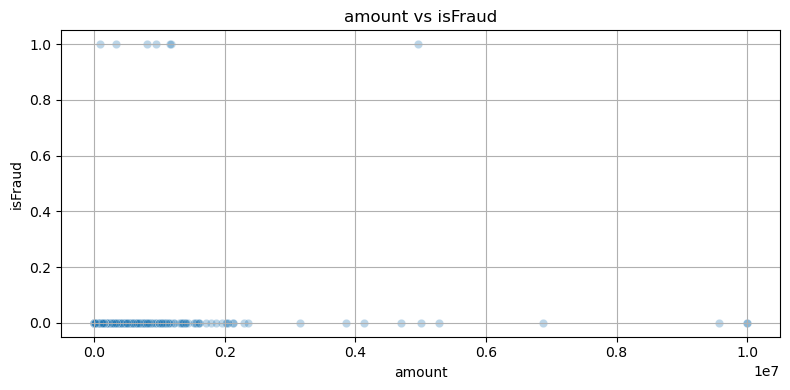

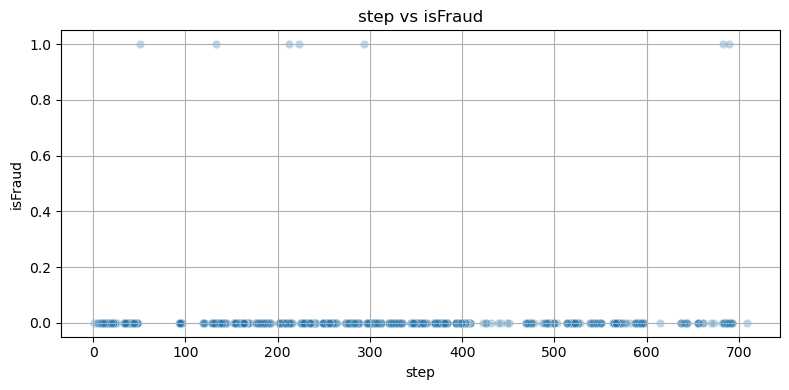

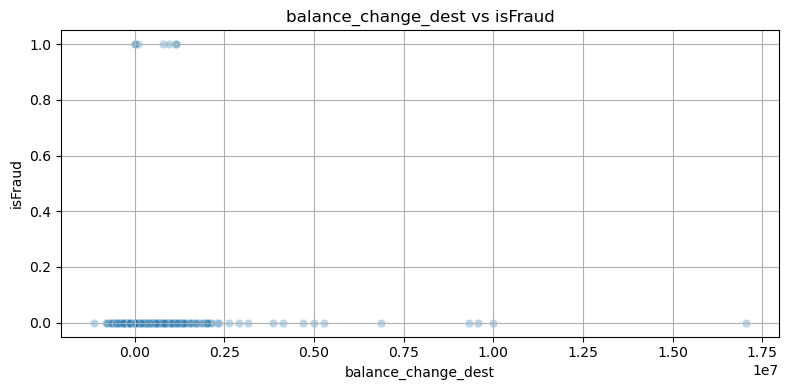

In [57]:
plot_scatter_vs_target(df)

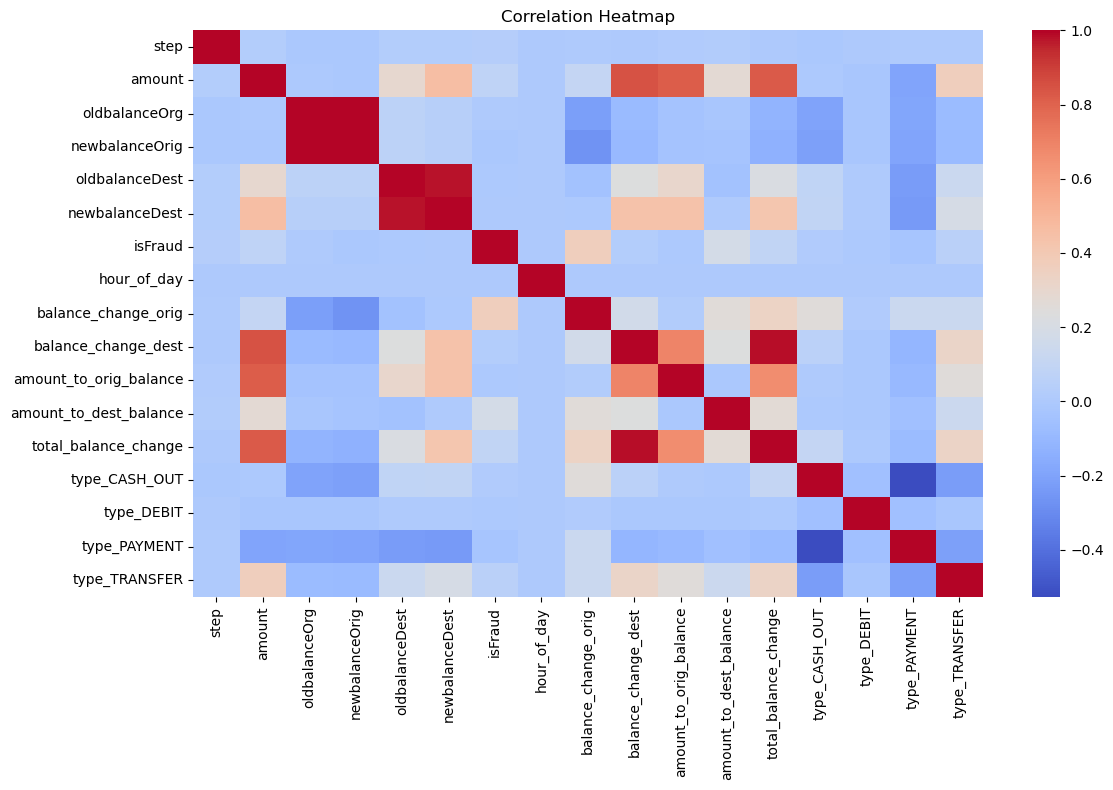

In [59]:
fast_correlation_heatmap(df)


C:\Users\himan\AppData\Local\Temp\ipykernel_34504\133201923.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\himan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


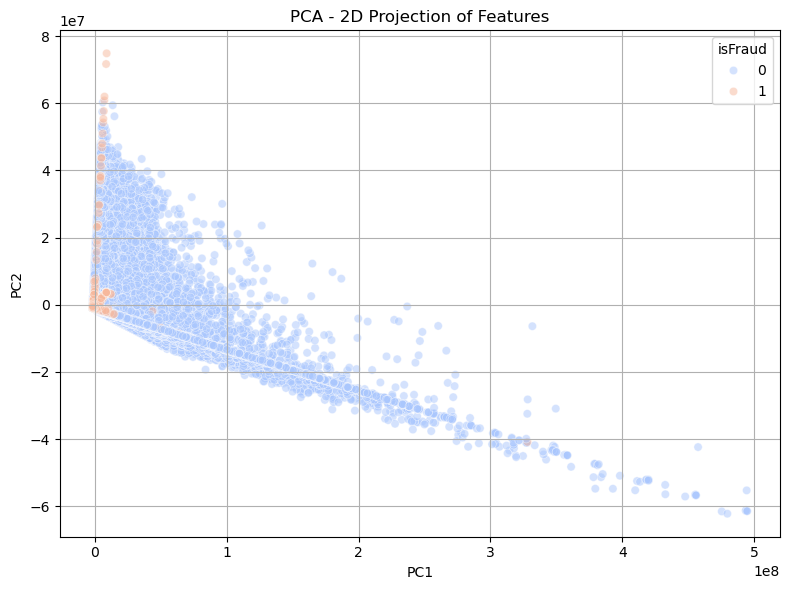

In [61]:
plot_pca_2d(df)

In [45]:
# Preprocessing
X_train, X_test, y_train, y_test, scaler, selector, selected_features = preprocess_data(df)

In [47]:
#  Handle imbalance
X_train_res, y_train_res = balance_data(X_train, y_train)

Class distribution after SMOTE:
isFraud
0    5083526
1    5083526
Name: count, dtype: int64


In [42]:

'''
# Model Training and Evaluation
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    start_time = time.time()
    
    # Fit model with early stopping for efficiency
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Print results
    print(f"\n=== {model_name} Results ===")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Mean CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.3f}")
    
    return model, y_pred, y_proba
    '''


In [69]:
'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models_and_parameters = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=500),
        'params': {'C': [0.1, 1, 10]}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {'max_depth': [5, 10, 15]}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [50, 100], 'max_depth': [5, 10]}
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {'C': [0.5, 1], 'kernel': ['rbf', 'linear']}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7]}
    },
    'MLP (ANN)': {
        'model': MLPClassifier(max_iter=300),
        'params': {'hidden_layer_sizes': [(64,), (64, 32)]}
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {'n_estimators': [100], 'max_depth': [3, 5]}
    },
    'LightGBM': {
        'model': LGBMClassifier(),
        'params': {'n_estimators': [100], 'learning_rate': [0.1, 0.05]}
    },
    'CatBoost': {
        'model': CatBoostClassifier(verbose=0),
        'params': {'depth': [4, 6]}
    }
}
'''


In [ ]:
'''
from sklearn.linear_model import LogisticRegression

clf = GridSearchCV(LogisticRegression(max_iter=500), {'C': [0.1, 1, 10]}, cv=3, scoring='f1', n_jobs=-1)
clf.fit(X_train_res, y_train_res)
lr_model = clf.best_estimator_
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]

print("🔍 Logistic Regression")
print("Best Params:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

'''

In [49]:
!pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 18.9 MB/s eta 0:00:00


In [53]:
!pip install catboost


   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   --- ------------------------------------ 8.4/102.4 MB 43.5 MB/s eta 0:00:03
   ------ --------------------------------- 16.0/102.4 MB 40.3 MB/s eta 0:00:03
   --------- ------------------------------ 24.1/102.4 MB 39.2 MB/s eta 0:00:02
   ------------- -------------------------- 33.3/102.4 MB 40.7 MB/s eta 0:00:02
   ----------------- ---------------------- 43.8/102.4 MB 42.9 MB/s eta 0:00:02
   --------------------- ------------------ 55.1/102.4 MB 44.9 MB/s eta 0:00:02
   ------------------------- -------------- 65.5/102.4 MB 45.9 MB/s eta 0:00:01
   ------------------------------ --------- 77.1/102.4 MB 47.3 MB/s eta 0:00:01
   --------------------------------- ------ 85.5/102.4 MB 46.2 MB/s eta 0:00:01
   ------------------------------------- -- 95.9/102.4 MB 46.4 MB/s eta 0:00:01
   --------------------------------------  102.2/102.4 MB 47.3 MB/s eta 0:00:01
   --------------------------------------  102.2/1

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression

clf = GridSearchCV(LogisticRegression(max_iter=500), {'C': [0.1, 1, 10]}, cv=3, scoring='f1', n_jobs=-1)
clf.fit(X_train_res, y_train_res)
lr_model = clf.best_estimator_
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print("Best Params:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


🔍 Logistic Regression
Best Params: {'C': 10}
Accuracy: 0.948655585277763
F1 Score: 0.04641183939752178
ROC AUC: 0.992252219523786


# Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier

clf = GridSearchCV(DecisionTreeClassifier(), {'max_depth': [5, 10, 15]}, cv=3, scoring='f1', n_jobs=-1)
clf.fit(X_train_res, y_train_res)
dt_model = clf.best_estimator_
y_pred = dt_model.predict(X_test)
y_proba = dt_model.predict_proba(X_test)[:, 1]

print("Decision Tree")
print("Best Params:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


🔍 Decision Tree
Best Params: {'max_depth': 15}
Accuracy: 0.9911930934112049
F1 Score: 0.2235155546317467
ROC AUC: 0.9906704175250908


# Random Forest

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

best_f1 = 0
best_thresh = 0

for thresh in np.arange(0.1, 0.6, 0.05):
    y_pred_thresh = (y_proba > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"Threshold: {thresh:.2f}, F1 Score: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"\nBest Threshold: {best_thresh}, Best F1: {best_f1}")


In [69]:
from sklearn.ensemble import RandomForestClassifier

clf = GridSearchCV(RandomForestClassifier(), {'n_estimators': [50, 100], 'max_depth': [5, 10]}, cv=3, scoring='f1', n_jobs=-1)
clf.fit(X_train_res, y_train_res)
rf_model = clf.best_estimator_
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest")
print("Best Params:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Random Forest
Best Params: {'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.9801229682112086
F1 Score: 0.11410759316335108
ROC AUC: 0.9989957323890397


# Naive Bayes

In [70]:
from sklearn.naive_bayes import GaussianNB

clf = GridSearchCV(GaussianNB(), {}, cv=3, scoring='f1', n_jobs=-1)
clf.fit(X_train_res, y_train_res)
nb_model = clf.best_estimator_
y_pred = nb_model.predict(X_test)
y_proba = nb_model.predict_proba(X_test)[:, 1]

print("Naive Bayes")
print("Best Params:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Naive Bayes
Best Params: {}
Accuracy: 0.8478464846242586
F1 Score: 0.014536200534419137
ROC AUC: 0.9335998521933413


# K-Nearest Neighbors

In [51]:
from sklearn.neighbors import KNeighborsClassifier

clf = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}, cv=3, scoring='f1', n_jobs=-1)
clf.fit(X_train_res, y_train_res)
knn_model = clf.best_estimator_
y_pred = knn_model.predict(X_test)
y_proba = knn_model.predict_proba(X_test)[:, 1]

print("KNN")
print("Best Params:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


KNN
Best Params: {'n_neighbors': 3}
Accuracy: 0.9964197138914472
F1 Score: 0.3879634605051048
ROC AUC: 0.9449063519866708


# MLP (ANN)

In [53]:
from sklearn.neural_network import MLPClassifier

clf = GridSearchCV(MLPClassifier(max_iter=300), {'hidden_layer_sizes': [(64,), (64, 32)]}, cv=3, scoring='f1', n_jobs=-1)
clf.fit(X_train_res, y_train_res)
mlp_model = clf.best_estimator_
y_pred = mlp_model.predict(X_test)
y_proba = mlp_model.predict_proba(X_test)[:, 1]

print("MLP (ANN)")
print("Best Params:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
 

MLP (ANN)
Best Params: {'hidden_layer_sizes': (64, 32)}
Accuracy: 0.9966091012821762
F1 Score: 0.4303630363036304
ROC AUC: 0.9989272953363422


#  XGBoost

In [55]:
from xgboost import XGBClassifier

clf = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                   {'n_estimators': [100], 'max_depth': [3, 5]},
                   cv=3, scoring='f1', n_jobs=-1)
clf.fit(X_train_res, y_train_res)
xgb_model = clf.best_estimator_
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost")
print("Best Params:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


C:\Users\vuttunoori bhavana\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost
Best Params: {'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.9942091465465485
F1 Score: 0.3067080628469282
ROC AUC: 0.999466937568021


# LightGBM

In [57]:
from lightgbm import LGBMClassifier

clf = GridSearchCV(LGBMClassifier(), {'n_estimators': [100], 'learning_rate': [0.1, 0.05]}, cv=3, scoring='f1', n_jobs=-1)
clf.fit(X_train_res, y_train_res)
lgb_model = clf.best_estimator_
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]

print("LightGBM")
print("Best Params:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


[LightGBM] [Info] Number of positive: 5083526, number of negative: 5083526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.445462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1810
[LightGBM] [Info] Number of data points in the train set: 10167052, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM
Best Params: {'learning_rate': 0.1, 'n_estimators': 100}
Accuracy: 0.9908316071052491
F1 Score: 0.21871023906783635
ROC AUC: 0.9989681038393137


# CatBoost

In [59]:
from catboost import CatBoostClassifier

clf = GridSearchCV(CatBoostClassifier(verbose=0), {'depth': [4, 6]}, cv=3, scoring='f1', n_jobs=-1)
clf.fit(X_train_res, y_train_res)
cat_model = clf.best_estimator_
y_pred = cat_model.predict(X_test)
y_proba = cat_model.predict_proba(X_test)[:, 1]

print("CatBoost")
print("Best Params:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


CatBoost
Best Params: {'depth': 6}
Accuracy: 0.9953533292888779
F1 Score: 0.3549689102214465
ROC AUC: 0.9991363872811541


+----+---------------------+------------+------------+-----------+
|    | Model               |   Accuracy |   F1 Score |   ROC AUC |
+====+=====================+============+============+===========+
|  0 | XGBoost             |     0.9942 |     0.3067 |    0.9996 |
+----+---------------------+------------+------------+-----------+
|  1 | CatBoost            |     0.9953 |     0.3549 |    0.9991 |
+----+---------------------+------------+------------+-----------+
|  2 | MLP (ANN)           |     0.9966 |     0.4383 |    0.9989 |
+----+---------------------+------------+------------+-----------+
|  3 | LightGBM            |     0.9908 |     0.2187 |    0.9989 |
+----+---------------------+------------+------------+-----------+
|  4 | Random Forest       |     0.9801 |     0.1141 |    0.9909 |
+----+---------------------+------------+------------+-----------+
|  5 | Decision Tree       |     0.9912 |     0.2232 |    0.9907 |
+----+---------------------+------------+------------+--------

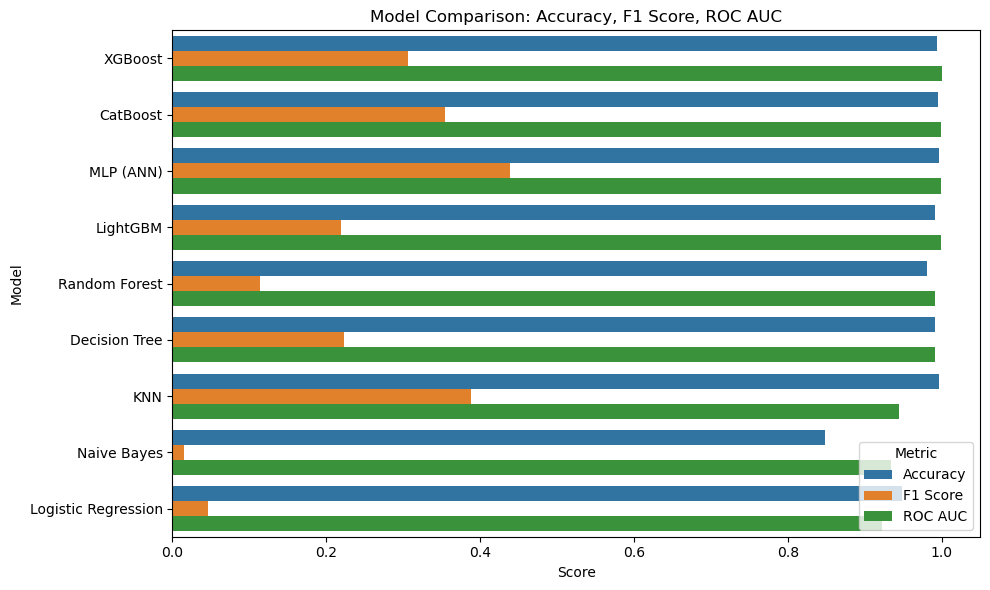


 Final Selected Model: MLP (ANN)
Metrics:
- Accuracy: 0.9966
- F1 Score: 0.4383
- ROC AUC: 0.9989
Final model saved as 'final_mlp_model.pkl'


In [73]:
import pandas as pd
import joblib
from tabulate import tabulate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create Model Results DataFrame
model_results = [
    ["Logistic Regression", 0.9487, 0.0464, 0.9222],
    ["Decision Tree", 0.9912, 0.2232, 0.9907],
    ["Random Forest", 0.9801, 0.1141, 0.9909],
    ["Naive Bayes", 0.8478, 0.0145, 0.9336],
    ["KNN", 0.9964, 0.3879, 0.9449],
    ["MLP (ANN)", 0.9966, 0.4383, 0.9989],
    ["XGBoost", 0.9942, 0.3067, 0.9996],
    ["LightGBM", 0.9908, 0.2187, 0.9989],
    ["CatBoost", 0.9953, 0.3549, 0.9991]
]

headers = ["Model", "Accuracy", "F1 Score", "ROC AUC"]
comparison_df = pd.DataFrame(model_results, columns=headers)
comparison_df = comparison_df.sort_values(by="ROC AUC", ascending=False).reset_index(drop=True)

# Step 2: Print Model Comparison Table
print(tabulate(comparison_df, headers="keys", tablefmt="grid"))

# Step 3: Plot Model Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df.melt(id_vars="Model"), x="value", y="Model", hue="variable")
plt.title("Model Comparison: Accuracy, F1 Score, ROC AUC")
plt.xlabel("Score")
plt.ylabel("Model")
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("model_comparison_plot.png")
plt.show()

#  Step 4: Select Final Model
final_model_name = "MLP (ANN)"
final_model_metrics = {
    "Accuracy": 0.9966,
    "F1 Score": 0.4383,
    "ROC AUC": 0.9989
}

print(f"\n Final Selected Model: {final_model_name}")
print("Metrics:")
for k, v in final_model_metrics.items():
    print(f"- {k}: {v}")

# Save Final Model
joblib.dump(mlp_model, "final_mlp_model.pkl")
print("Final model saved as 'final_mlp_model.pkl'")
